In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SeparableConv1D, Conv1D,Dropout, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, roc_auc_score

In [8]:
FOLDS = 5
PADDING = 100
LAYERS = 1
MAX_POWER = 6
KERNEL_SIZE = 3
POOL_SIZE = 2
DROPOUT = 0.25
ACTIVATION = 'sigmoid'
LAST_ACTIVATION = 'softmax'

# Prepare training batches
input_data = pk.load(open('input_data3.pkl', 'rb'))
target_data = pk.load(open('target_data3.pkl', 'rb'))
model_input = []
model_target = []
for i, t in zip(input_data, target_data):
    model_input.append(np.concatenate([np.zeros((PADDING - 1, i.shape[1])), i])[:PADDING,:])
    model_target.append(np.argmax(t))
model_input = np.array(model_input)
model_target = np.array(model_target)

#keys, values = np.unique(model_target, return_counts=True)
#values = (1 / values) / max((1 / values))
#class_weight = dict(zip(keys, values))
class_weight = dict(zip(np.arange(target_data[0].size), np.ones((target_data[0].size,))))

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
mms = MinMaxScaler()

layers = []
dimention = []
auc = []
kappa = []
for lay in range(1,LAYERS+1):
    for dim in np.power(2, np.arange(MAX_POWER+1)):
        print(f'layers: {lay}, nodes: {dim}')
        aucs = []
        kappas = []
        
        # Prepare k-fold training and test sets
        for train_index, test_index in skf.split(model_input, model_target):
            model_target[train_index.astype(int)]
            X_train_raw, X_test_raw = model_input[train_index], model_input[test_index]
            y_train_raw, y_test_raw = model_target[train_index], model_target[test_index]
            
            X_train = np.stack(X_train_raw)
            X_test = np.stack(X_test_raw)
            
            y_train = np.zeros((y_train_raw.size, y_train_raw.max() + 1))
            y_train[np.arange(y_train_raw.size),y_train_raw] = 1
            y_test = np.zeros((y_test_raw.size, y_test_raw.max() + 1))
            y_test[np.arange(y_test_raw.size),y_test_raw] = 1
            
            # Make the LSTM
            model = Sequential()
            model.add(Conv1D(filters=dim, kernel_size=KERNEL_SIZE, activation=ACTIVATION, padding='same', input_shape=(PADDING, model_input[0].shape[1])))
            for l in range(lay-1):
                model.add(Conv1D(filters=dim, kernel_size=KERNEL_SIZE, activation=ACTIVATION, padding='same'))
                model.add(Dropout(DROPOUT))
                model.add(MaxPooling1D(pool_size=POOL_SIZE))
            model.add(Flatten())
            model.add(Dense(dim, activation=ACTIVATION))
            model.add(Dense(target_data[0].size, activation=LAST_ACTIVATION))
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            es = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0, restore_best_weights=True)]
            model.fit(X_train, y_train, epochs=1000, validation_split=0.25, callbacks=es, verbose=True)
            
            # Get the average auc and kappa for all affects and folds
            y_pred = model.predict(X_test, batch_size=1)
            for y_t, y_p in zip(y_test.T, y_pred.T):
                #y_p = mms.fit_transform(y_p.reshape(-1, 1))
                aucs.append(roc_auc_score(y_t, y_p))
                kappas.append(cohen_kappa_score(y_t, np.around(y_p)))
        
        layers.append(lay)
        dimention.append(dim)
        auc.append(np.mean(aucs))
        kappa.append(np.mean(kappas))
        print(f'auc: {auc[-1]}')
        print(f'kappa: {kappa[-1]}')

layers: 1, nodes: 1
Train on 1854 samples, validate on 618 samples
Epoch 1/1000
1854/1854 [==============================] - 1s 491us/step - loss: 1.5102 - accuracy: 0.0329 - val_loss: 1.3690 - val_accuracy: 0.0566
Epoch 2/1000
1854/1854 [==============================] - 0s 185us/step - loss: 1.3241 - accuracy: 0.7379 - val_loss: 1.2780 - val_accuracy: 0.8447
Epoch 3/1000
1854/1854 [==============================] - 0s 186us/step - loss: 1.2522 - accuracy: 0.8193 - val_loss: 1.2137 - val_accuracy: 0.8447
Epoch 4/1000
1854/1854 [==============================] - 0s 183us/step - loss: 1.1944 - accuracy: 0.8193 - val_loss: 1.1561 - val_accuracy: 0.8447
Epoch 5/1000
1854/1854 [==============================] - 0s 185us/step - loss: 1.1424 - accuracy: 0.8193 - val_loss: 1.1045 - val_accuracy: 0.8447
Epoch 6/1000
1854/1854 [==============================] - 0s 187us/step - loss: 1.0951 - accuracy: 0.8193 - val_loss: 1.0568 - val_accuracy: 0.8447
Epoch 7/1000
1854/1854 [=====================

1854/1854 [==============================] - 0s 194us/step - loss: 0.6445 - accuracy: 0.8193 - val_loss: 0.6074 - val_accuracy: 0.8447
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
1854/1854 [==============================] - 1s 485us/step - loss: 1.2929 - accuracy: 0.1127 - val_loss: 1.2327 - val_accuracy: 0.0598
Epoch 2/1000
1854/1854 [==============================] - 0s 187us/step - loss: 1.1708 - accuracy: 0.7039 - val_loss: 1.1101 - val_accuracy: 0.8611
Epoch 3/1000
1854/1854 [==============================] - 0s 192us/step - loss: 1.0689 - accuracy: 0.8134 - val_loss: 1.0089 - val_accuracy: 0.8611
Epoch 4/1000
1854/1854 [==============================] - 0s 201us/step - loss: 0.9849 - accuracy: 0.8134 - val_loss: 0.9232 - val_accuracy: 0.8611
Epoch 5/1000
1854/1854 [==============================] - 0s 189us/step - loss: 0.9159 - accuracy: 0.8134 - val_loss: 0.8532 - val_accuracy: 0.8611
Epoch 6/1000
1854/1854 [==============================] - 0s 186us/step - loss

1856/1856 [==============================] - 0s 188us/step - loss: 0.7225 - accuracy: 0.8190 - val_loss: 0.6837 - val_accuracy: 0.8433
Epoch 23/1000
1856/1856 [==============================] - 0s 188us/step - loss: 0.7142 - accuracy: 0.8190 - val_loss: 0.6755 - val_accuracy: 0.8433
Epoch 24/1000
1856/1856 [==============================] - 0s 183us/step - loss: 0.7068 - accuracy: 0.8190 - val_loss: 0.6678 - val_accuracy: 0.8433
Epoch 25/1000
1856/1856 [==============================] - 0s 185us/step - loss: 0.7001 - accuracy: 0.8190 - val_loss: 0.6617 - val_accuracy: 0.8433
Epoch 26/1000
1856/1856 [==============================] - 0s 185us/step - loss: 0.6942 - accuracy: 0.8190 - val_loss: 0.6557 - val_accuracy: 0.8433
Epoch 27/1000
1856/1856 [==============================] - 0s 184us/step - loss: 0.6889 - accuracy: 0.8190 - val_loss: 0.6505 - val_accuracy: 0.8433
Epoch 28/1000
1856/1856 [==============================] - 0s 190us/step - loss: 0.6841 - accuracy: 0.8190 - val_loss: 0

Epoch 26/1000
1857/1857 [==============================] - 0s 183us/step - loss: 0.6496 - accuracy: 0.8191 - val_loss: 0.6085 - val_accuracy: 0.8417
Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/1857 [==============================] - 1s 478us/step - loss: 1.3743 - accuracy: 0.2768 - val_loss: 1.3303 - val_accuracy: 0.8271
Epoch 2/1000
1857/1857 [==============================] - 0s 185us/step - loss: 1.2918 - accuracy: 0.8239 - val_loss: 1.2642 - val_accuracy: 0.8271
Epoch 3/1000
1857/1857 [==============================] - 0s 193us/step - loss: 1.2319 - accuracy: 0.8239 - val_loss: 1.2075 - val_accuracy: 0.8271
Epoch 4/1000
1857/1857 [==============================] - 0s 193us/step - loss: 1.1741 - accuracy: 0.8239 - val_loss: 1.1531 - val_accuracy: 0.8271
Epoch 5/1000
1857/1857 [==============================] - 0s 185us/step - loss: 1.1125 - accuracy: 0.8239 - val_loss: 1.0963 - val_accuracy: 0.8271
Epoch 6/1000
1857/1857 [==============================] - 0s 185

1854/1854 [==============================] - 0s 184us/step - loss: 0.6786 - accuracy: 0.8215 - val_loss: 0.6327 - val_accuracy: 0.8382
Epoch 14/1000
1854/1854 [==============================] - 0s 183us/step - loss: 0.6719 - accuracy: 0.8215 - val_loss: 0.6280 - val_accuracy: 0.8382
Epoch 15/1000
1854/1854 [==============================] - 0s 186us/step - loss: 0.6664 - accuracy: 0.8215 - val_loss: 0.6241 - val_accuracy: 0.8382
Epoch 16/1000
1854/1854 [==============================] - 0s 189us/step - loss: 0.6618 - accuracy: 0.8215 - val_loss: 0.6218 - val_accuracy: 0.8382
Epoch 17/1000
1854/1854 [==============================] - 0s 190us/step - loss: 0.6581 - accuracy: 0.8215 - val_loss: 0.6195 - val_accuracy: 0.8382
Epoch 18/1000
1854/1854 [==============================] - 0s 193us/step - loss: 0.6549 - accuracy: 0.8215 - val_loss: 0.6184 - val_accuracy: 0.8382
Epoch 19/1000
1854/1854 [==============================] - 0s 187us/step - loss: 0.6523 - accuracy: 0.8215 - val_loss: 0

1856/1856 [==============================] - 0s 200us/step - loss: 0.6564 - accuracy: 0.8152 - val_loss: 0.5994 - val_accuracy: 0.8546
Epoch 12/1000
1856/1856 [==============================] - 0s 199us/step - loss: 0.6548 - accuracy: 0.8152 - val_loss: 0.5970 - val_accuracy: 0.8546
Epoch 13/1000
1856/1856 [==============================] - 0s 191us/step - loss: 0.6537 - accuracy: 0.8152 - val_loss: 0.5957 - val_accuracy: 0.8546
Epoch 14/1000
1856/1856 [==============================] - 0s 210us/step - loss: 0.6530 - accuracy: 0.8152 - val_loss: 0.5944 - val_accuracy: 0.8546
Epoch 15/1000
1856/1856 [==============================] - 0s 202us/step - loss: 0.6525 - accuracy: 0.8152 - val_loss: 0.5932 - val_accuracy: 0.8546
Epoch 16/1000
1856/1856 [==============================] - 0s 199us/step - loss: 0.6522 - accuracy: 0.8152 - val_loss: 0.5930 - val_accuracy: 0.8546
Epoch 17/1000
1856/1856 [==============================] - 0s 191us/step - loss: 0.6520 - accuracy: 0.8152 - val_loss: 0

1857/1857 [==============================] - 0s 195us/step - loss: 0.6900 - accuracy: 0.8180 - val_loss: 0.6443 - val_accuracy: 0.8449
Epoch 28/1000
1857/1857 [==============================] - 0s 195us/step - loss: 0.6853 - accuracy: 0.8180 - val_loss: 0.6397 - val_accuracy: 0.8449
Epoch 29/1000
1857/1857 [==============================] - 0s 197us/step - loss: 0.6812 - accuracy: 0.8180 - val_loss: 0.6351 - val_accuracy: 0.8449
Epoch 30/1000
1857/1857 [==============================] - 0s 193us/step - loss: 0.6774 - accuracy: 0.8180 - val_loss: 0.6312 - val_accuracy: 0.8449
Epoch 31/1000
1857/1857 [==============================] - 0s 193us/step - loss: 0.6741 - accuracy: 0.8180 - val_loss: 0.6280 - val_accuracy: 0.8449
Epoch 32/1000
1857/1857 [==============================] - 0s 192us/step - loss: 0.6717 - accuracy: 0.8180 - val_loss: 0.6258 - val_accuracy: 0.8449
Epoch 33/1000
1857/1857 [==============================] - 0s 195us/step - loss: 0.6691 - accuracy: 0.8180 - val_loss: 0

1854/1854 [==============================] - 0s 197us/step - loss: 0.6878 - accuracy: 0.8177 - val_loss: 0.6312 - val_accuracy: 0.8495
Epoch 29/1000
1854/1854 [==============================] - 0s 192us/step - loss: 0.6836 - accuracy: 0.8177 - val_loss: 0.6267 - val_accuracy: 0.8495
Epoch 30/1000
1854/1854 [==============================] - 0s 192us/step - loss: 0.6798 - accuracy: 0.8177 - val_loss: 0.6228 - val_accuracy: 0.8495
Epoch 31/1000
1854/1854 [==============================] - 0s 190us/step - loss: 0.6764 - accuracy: 0.8177 - val_loss: 0.6194 - val_accuracy: 0.8495
Epoch 32/1000
1854/1854 [==============================] - 0s 192us/step - loss: 0.6734 - accuracy: 0.8177 - val_loss: 0.6160 - val_accuracy: 0.8495
Epoch 33/1000
1854/1854 [==============================] - 0s 195us/step - loss: 0.6707 - accuracy: 0.8177 - val_loss: 0.6133 - val_accuracy: 0.8495
Epoch 34/1000
1854/1854 [==============================] - 0s 193us/step - loss: 0.6683 - accuracy: 0.8177 - val_loss: 0

1857/1857 [==============================] - 0s 200us/step - loss: 0.7998 - accuracy: 0.8218 - val_loss: 0.7805 - val_accuracy: 0.8336
Epoch 8/1000
1857/1857 [==============================] - 0s 195us/step - loss: 0.7662 - accuracy: 0.8218 - val_loss: 0.7503 - val_accuracy: 0.8336
Epoch 9/1000
1857/1857 [==============================] - 0s 202us/step - loss: 0.7397 - accuracy: 0.8218 - val_loss: 0.7264 - val_accuracy: 0.8336
Epoch 10/1000
1857/1857 [==============================] - 0s 199us/step - loss: 0.7188 - accuracy: 0.8218 - val_loss: 0.7074 - val_accuracy: 0.8336
Epoch 11/1000
1857/1857 [==============================] - 0s 197us/step - loss: 0.7021 - accuracy: 0.8218 - val_loss: 0.6928 - val_accuracy: 0.8336
Epoch 12/1000
1857/1857 [==============================] - 0s 209us/step - loss: 0.6891 - accuracy: 0.8218 - val_loss: 0.6812 - val_accuracy: 0.8336
Epoch 13/1000
1857/1857 [==============================] - 0s 204us/step - loss: 0.6787 - accuracy: 0.8218 - val_loss: 0.6

Epoch 34/1000
1857/1857 [==============================] - 0s 206us/step - loss: 0.6676 - accuracy: 0.8174 - val_loss: 0.6200 - val_accuracy: 0.8465
Epoch 35/1000
1857/1857 [==============================] - 0s 212us/step - loss: 0.6654 - accuracy: 0.8174 - val_loss: 0.6179 - val_accuracy: 0.8465
Epoch 36/1000
1857/1857 [==============================] - 0s 216us/step - loss: 0.6634 - accuracy: 0.8174 - val_loss: 0.6160 - val_accuracy: 0.8465
Epoch 37/1000
1857/1857 [==============================] - 0s 197us/step - loss: 0.6617 - accuracy: 0.8174 - val_loss: 0.6142 - val_accuracy: 0.8465
Epoch 38/1000
1857/1857 [==============================] - 0s 201us/step - loss: 0.6600 - accuracy: 0.8174 - val_loss: 0.6130 - val_accuracy: 0.8465
Epoch 39/1000
1857/1857 [==============================] - 0s 209us/step - loss: 0.6586 - accuracy: 0.8174 - val_loss: 0.6118 - val_accuracy: 0.8465
Epoch 40/1000
1857/1857 [==============================] - 0s 208us/step - loss: 0.6573 - accuracy: 0.8174

Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/1857 [==============================] - 1s 537us/step - loss: 0.6603 - accuracy: 0.8174 - val_loss: 0.6065 - val_accuracy: 0.8465
Epoch 2/1000
1857/1857 [==============================] - 0s 205us/step - loss: 0.6506 - accuracy: 0.8174 - val_loss: 0.6242 - val_accuracy: 0.8465
Epoch 3/1000
1857/1857 [==============================] - 0s 207us/step - loss: 0.6532 - accuracy: 0.8174 - val_loss: 0.6010 - val_accuracy: 0.8465
Epoch 4/1000
1857/1857 [==============================] - 0s 198us/step - loss: 0.6445 - accuracy: 0.8174 - val_loss: 0.6028 - val_accuracy: 0.8465
Epoch 5/1000
1857/1857 [==============================] - 0s 199us/step - loss: 0.6371 - accuracy: 0.8174 - val_loss: 0.6143 - val_accuracy: 0.8465
Epoch 6/1000
1857/1857 [==============================] - 0s 198us/step - loss: 0.6284 - accuracy: 0.8174 - val_loss: 0.6033 - val_accuracy: 0.8465
Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/

1857/1857 [==============================] - 0s 202us/step - loss: 0.6478 - accuracy: 0.8174 - val_loss: 0.6081 - val_accuracy: 0.8465
Epoch 5/1000
1857/1857 [==============================] - 0s 204us/step - loss: 0.6473 - accuracy: 0.8174 - val_loss: 0.6125 - val_accuracy: 0.8465
Epoch 6/1000
1857/1857 [==============================] - 0s 204us/step - loss: 0.6470 - accuracy: 0.8174 - val_loss: 0.6105 - val_accuracy: 0.8465
Epoch 7/1000
1857/1857 [==============================] - 0s 207us/step - loss: 0.6469 - accuracy: 0.8174 - val_loss: 0.6115 - val_accuracy: 0.8465
auc: 0.6464831473914365
kappa: 0.0
layers: 1, nodes: 32
Train on 1854 samples, validate on 618 samples
Epoch 1/1000
1854/1854 [==============================] - 1s 576us/step - loss: 0.7115 - accuracy: 0.8064 - val_loss: 0.6351 - val_accuracy: 0.8414
Epoch 2/1000
1854/1854 [==============================] - 0s 205us/step - loss: 0.6418 - accuracy: 0.8204 - val_loss: 0.6242 - val_accuracy: 0.8414
Epoch 3/1000
1854/1854

Epoch 5/1000
1857/1857 [==============================] - 0s 222us/step - loss: 0.6372 - accuracy: 0.8218 - val_loss: 0.6496 - val_accuracy: 0.8336
Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/1857 [==============================] - 1s 631us/step - loss: 0.7427 - accuracy: 0.8040 - val_loss: 0.6291 - val_accuracy: 0.8498
Epoch 2/1000
1857/1857 [==============================] - 0s 221us/step - loss: 0.6528 - accuracy: 0.8164 - val_loss: 0.6031 - val_accuracy: 0.8498
Epoch 3/1000
1857/1857 [==============================] - 0s 219us/step - loss: 0.6516 - accuracy: 0.8164 - val_loss: 0.6027 - val_accuracy: 0.8498
Epoch 4/1000
1857/1857 [==============================] - 0s 223us/step - loss: 0.6511 - accuracy: 0.8164 - val_loss: 0.5956 - val_accuracy: 0.8498
Epoch 5/1000
1857/1857 [==============================] - 0s 221us/step - loss: 0.6509 - accuracy: 0.8164 - val_loss: 0.6193 - val_accuracy: 0.8498
Epoch 6/1000
1857/1857 [==============================] - 0s 223u

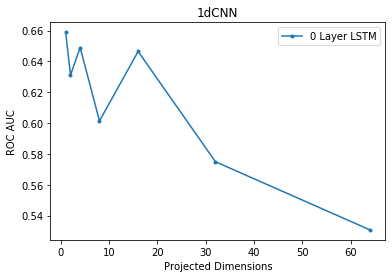

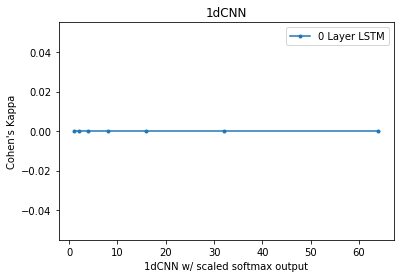

In [9]:
plt.figure()
for i in range(LAYERS):
    start = int(i*(MAX_POWER+1))
    end = int(i*(MAX_POWER+1)+MAX_POWER+1)
    plt.plot(dimention[start:end], auc[start:end], marker='.', label=f'{i} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('ROC AUC')
plt.title('1dCNN')
plt.legend()
plt.show()

plt.figure()
for i in range(LAYERS):
    start = int(i*(MAX_POWER+1))
    end = int(i*(MAX_POWER+1)+MAX_POWER+1)
    plt.plot(dimention[start:end], kappa[start:end], marker='.', label=f'{i} Layer LSTM')
plt.xlabel('1dCNN w/ scaled softmax output')
plt.ylabel('Cohen\'s Kappa')
plt.title('1dCNN')
plt.legend()
plt.show()

In [10]:
FOLDS = 5
PADDING = 100
LAYERS = 1
MAX_POWER = 6
KERNEL_SIZE = 3
POOL_SIZE = 2
DROPOUT = 0.25
ACTIVATION = 'sigmoid'
LAST_ACTIVATION = 'softmax'

# Prepare training batches
input_data = pk.load(open('input_data2.pkl', 'rb'))
target_data = pk.load(open('target_data2.pkl', 'rb'))
model_input = []
model_target = []
for i, t in zip(input_data, target_data):
    model_input.append(np.concatenate([np.zeros((PADDING - 1, i.shape[1])), i])[:PADDING,:])
    model_target.append(np.argmax(t))
model_input = np.array(model_input)
model_target = np.array(model_target)

#keys, values = np.unique(model_target, return_counts=True)
#values = (1 / values) / max((1 / values))
#class_weight = dict(zip(keys, values))
class_weight = dict(zip(np.arange(target_data[0].size), np.ones((target_data[0].size,))))

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
mms = MinMaxScaler()

layers = []
dimention = []
auc = []
kappa = []
for lay in range(1,LAYERS+1):
    for dim in np.power(2, np.arange(MAX_POWER+1)):
        print(f'layers: {lay}, nodes: {dim}')
        aucs = []
        kappas = []
        
        # Prepare k-fold training and test sets
        for train_index, test_index in skf.split(model_input, model_target):
            model_target[train_index.astype(int)]
            X_train_raw, X_test_raw = model_input[train_index], model_input[test_index]
            y_train_raw, y_test_raw = model_target[train_index], model_target[test_index]
            
            X_train = np.stack(X_train_raw)
            X_test = np.stack(X_test_raw)
            
            y_train = np.zeros((y_train_raw.size, y_train_raw.max() + 1))
            y_train[np.arange(y_train_raw.size),y_train_raw] = 1
            y_test = np.zeros((y_test_raw.size, y_test_raw.max() + 1))
            y_test[np.arange(y_test_raw.size),y_test_raw] = 1
            
            # Make the LSTM
            model = Sequential()
            model.add(Conv1D(filters=dim, kernel_size=KERNEL_SIZE, activation=ACTIVATION, padding='same', input_shape=(PADDING, model_input[0].shape[1])))
            for l in range(lay-1):
                model.add(Conv1D(filters=dim, kernel_size=KERNEL_SIZE, activation=ACTIVATION, padding='same'))
                model.add(Dropout(DROPOUT))
                model.add(MaxPooling1D(pool_size=POOL_SIZE))
            model.add(Flatten())
            model.add(Dense(dim, activation=ACTIVATION))
            model.add(Dense(target_data[0].size, activation=LAST_ACTIVATION))
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            es = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0, restore_best_weights=True)]
            model.fit(X_train, y_train, epochs=1000, validation_split=0.25, callbacks=es, verbose=True)
            
            # Get the average auc and kappa for all affects and folds
            y_pred = model.predict(X_test, batch_size=1)
            for y_t, y_p in zip(y_test.T, y_pred.T):
                #y_p = mms.fit_transform(y_p.reshape(-1, 1))
                aucs.append(roc_auc_score(y_t, y_p))
                kappas.append(cohen_kappa_score(y_t, np.around(y_p)))
        
        layers.append(lay)
        dimention.append(dim)
        auc.append(np.mean(aucs))
        kappa.append(np.mean(kappas))
        print(f'auc: {auc[-1]}')
        print(f'kappa: {kappa[-1]}')

layers: 1, nodes: 1
Train on 1854 samples, validate on 618 samples
Epoch 1/1000
1854/1854 [==============================] - 1s 617us/step - loss: 1.2635 - accuracy: 0.1230 - val_loss: 1.1997 - val_accuracy: 0.8382
Epoch 2/1000
1854/1854 [==============================] - 0s 204us/step - loss: 1.1365 - accuracy: 0.8215 - val_loss: 1.0835 - val_accuracy: 0.8382
Epoch 3/1000
1854/1854 [==============================] - 0s 208us/step - loss: 1.0353 - accuracy: 0.8215 - val_loss: 0.9881 - val_accuracy: 0.8382
Epoch 4/1000
1854/1854 [==============================] - ETA: 0s - loss: 0.9558 - accuracy: 0.82 - 0s 213us/step - loss: 0.9526 - accuracy: 0.8215 - val_loss: 0.9115 - val_accuracy: 0.8382
Epoch 5/1000
1854/1854 [==============================] - 0s 204us/step - loss: 0.8856 - accuracy: 0.8215 - val_loss: 0.8494 - val_accuracy: 0.8382
Epoch 6/1000
1854/1854 [==============================] - 0s 204us/step - loss: 0.8320 - accuracy: 0.8215 - val_loss: 0.7989 - val_accuracy: 0.8382
Epo

1854/1854 [==============================] - 0s 204us/step - loss: 0.6420 - accuracy: 0.8215 - val_loss: 0.6248 - val_accuracy: 0.8368
Train on 1856 samples, validate on 619 samples
Epoch 1/1000
1856/1856 [==============================] - 1s 623us/step - loss: 1.4418 - accuracy: 0.0566 - val_loss: 1.3495 - val_accuracy: 0.8094
Epoch 2/1000
1856/1856 [==============================] - 0s 206us/step - loss: 1.3075 - accuracy: 0.8157 - val_loss: 1.2674 - val_accuracy: 0.8514
Epoch 3/1000
1856/1856 [==============================] - 0s 206us/step - loss: 1.2431 - accuracy: 0.8163 - val_loss: 1.2043 - val_accuracy: 0.8514
Epoch 4/1000
1856/1856 [==============================] - 0s 210us/step - loss: 1.1876 - accuracy: 0.8163 - val_loss: 1.1485 - val_accuracy: 0.8514
Epoch 5/1000
1856/1856 [==============================] - 0s 211us/step - loss: 1.1371 - accuracy: 0.8163 - val_loss: 1.0968 - val_accuracy: 0.8514
Epoch 6/1000
1856/1856 [==============================] - 0s 206us/step - loss

1856/1856 [==============================] - 0s 206us/step - loss: 0.6524 - accuracy: 0.8163 - val_loss: 0.5942 - val_accuracy: 0.8514
Epoch 55/1000
1856/1856 [==============================] - 0s 204us/step - loss: 0.6522 - accuracy: 0.8163 - val_loss: 0.5942 - val_accuracy: 0.8514
Epoch 56/1000
1856/1856 [==============================] - 0s 205us/step - loss: 0.6520 - accuracy: 0.8163 - val_loss: 0.5941 - val_accuracy: 0.8514
Epoch 57/1000
1856/1856 [==============================] - 0s 207us/step - loss: 0.6518 - accuracy: 0.8163 - val_loss: 0.5942 - val_accuracy: 0.8514
Epoch 58/1000
1856/1856 [==============================] - 0s 208us/step - loss: 0.6516 - accuracy: 0.8163 - val_loss: 0.5945 - val_accuracy: 0.8514
Epoch 59/1000
1856/1856 [==============================] - 0s 209us/step - loss: 0.6514 - accuracy: 0.8163 - val_loss: 0.5945 - val_accuracy: 0.8514
Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/1857 [==============================] - 1s 650us/step -

1857/1857 [==============================] - 0s 213us/step - loss: 0.6921 - accuracy: 0.8191 - val_loss: 0.6528 - val_accuracy: 0.8417
Epoch 27/1000
1857/1857 [==============================] - 0s 227us/step - loss: 0.6869 - accuracy: 0.8191 - val_loss: 0.6477 - val_accuracy: 0.8417
Epoch 28/1000
1857/1857 [==============================] - 0s 226us/step - loss: 0.6822 - accuracy: 0.8191 - val_loss: 0.6429 - val_accuracy: 0.8417
Epoch 29/1000
1857/1857 [==============================] - 0s 216us/step - loss: 0.6780 - accuracy: 0.8191 - val_loss: 0.6384 - val_accuracy: 0.8417
Epoch 30/1000
1857/1857 [==============================] - 0s 213us/step - loss: 0.6742 - accuracy: 0.8191 - val_loss: 0.6337 - val_accuracy: 0.8417
Epoch 31/1000
1857/1857 [==============================] - 0s 212us/step - loss: 0.6698 - accuracy: 0.8191 - val_loss: 0.6257 - val_accuracy: 0.8417
Epoch 32/1000
1857/1857 [==============================] - 0s 211us/step - loss: 0.6617 - accuracy: 0.8191 - val_loss: 0

1854/1854 [==============================] - 0s 225us/step - loss: 0.6490 - accuracy: 0.8188 - val_loss: 0.6111 - val_accuracy: 0.8463
Epoch 45/1000
1854/1854 [==============================] - 0s 216us/step - loss: 0.6482 - accuracy: 0.8188 - val_loss: 0.6109 - val_accuracy: 0.8463
Epoch 46/1000
1854/1854 [==============================] - 0s 219us/step - loss: 0.6475 - accuracy: 0.8188 - val_loss: 0.6107 - val_accuracy: 0.8463
Epoch 47/1000
1854/1854 [==============================] - 0s 221us/step - loss: 0.6468 - accuracy: 0.8188 - val_loss: 0.6105 - val_accuracy: 0.8463
Epoch 48/1000
1854/1854 [==============================] - 0s 217us/step - loss: 0.6462 - accuracy: 0.8188 - val_loss: 0.6107 - val_accuracy: 0.8463
Epoch 49/1000
1854/1854 [==============================] - 0s 221us/step - loss: 0.6457 - accuracy: 0.8188 - val_loss: 0.6104 - val_accuracy: 0.8463
Epoch 50/1000
1854/1854 [==============================] - 0s 217us/step - loss: 0.6452 - accuracy: 0.8188 - val_loss: 0

1856/1856 [==============================] - 0s 232us/step - loss: 0.7780 - accuracy: 0.8222 - val_loss: 0.7548 - val_accuracy: 0.8336
Epoch 18/1000
1856/1856 [==============================] - 0s 218us/step - loss: 0.7633 - accuracy: 0.8222 - val_loss: 0.7408 - val_accuracy: 0.8336
Epoch 19/1000
1856/1856 [==============================] - 0s 212us/step - loss: 0.7501 - accuracy: 0.8222 - val_loss: 0.7281 - val_accuracy: 0.8336
Epoch 20/1000
1856/1856 [==============================] - 0s 215us/step - loss: 0.7383 - accuracy: 0.8222 - val_loss: 0.7168 - val_accuracy: 0.8336
Epoch 21/1000
1856/1856 [==============================] - 0s 212us/step - loss: 0.7277 - accuracy: 0.8222 - val_loss: 0.7069 - val_accuracy: 0.8336
Epoch 22/1000
1856/1856 [==============================] - 0s 211us/step - loss: 0.7182 - accuracy: 0.8222 - val_loss: 0.6978 - val_accuracy: 0.8336
Epoch 23/1000
1856/1856 [==============================] - 0s 212us/step - loss: 0.7097 - accuracy: 0.8222 - val_loss: 0

Epoch 22/1000
1857/1857 [==============================] - 0s 215us/step - loss: 0.7257 - accuracy: 0.8164 - val_loss: 0.6683 - val_accuracy: 0.8498
Epoch 23/1000
1857/1857 [==============================] - 0s 213us/step - loss: 0.7176 - accuracy: 0.8164 - val_loss: 0.6596 - val_accuracy: 0.8498
Epoch 24/1000
1857/1857 [==============================] - 0s 216us/step - loss: 0.7108 - accuracy: 0.8164 - val_loss: 0.6527 - val_accuracy: 0.8498
Epoch 25/1000
1857/1857 [==============================] - 0s 213us/step - loss: 0.7044 - accuracy: 0.8164 - val_loss: 0.6455 - val_accuracy: 0.8498
Epoch 26/1000
1857/1857 [==============================] - 0s 215us/step - loss: 0.6986 - accuracy: 0.8164 - val_loss: 0.6391 - val_accuracy: 0.8498
Epoch 27/1000
1857/1857 [==============================] - 0s 218us/step - loss: 0.6934 - accuracy: 0.8164 - val_loss: 0.6336 - val_accuracy: 0.8498
Epoch 28/1000
1857/1857 [==============================] - 0s 212us/step - loss: 0.6888 - accuracy: 0.8164

Epoch 25/1000
1857/1857 [==============================] - 0s 216us/step - loss: 0.6963 - accuracy: 0.8191 - val_loss: 0.6633 - val_accuracy: 0.8417
Epoch 26/1000
1857/1857 [==============================] - 0s 216us/step - loss: 0.6905 - accuracy: 0.8191 - val_loss: 0.6575 - val_accuracy: 0.8417
Epoch 27/1000
1857/1857 [==============================] - 0s 213us/step - loss: 0.6852 - accuracy: 0.8191 - val_loss: 0.6522 - val_accuracy: 0.8417
Epoch 28/1000
1857/1857 [==============================] - 0s 214us/step - loss: 0.6811 - accuracy: 0.8191 - val_loss: 0.6484 - val_accuracy: 0.8417
Epoch 29/1000
1857/1857 [==============================] - 0s 214us/step - loss: 0.6771 - accuracy: 0.8191 - val_loss: 0.6442 - val_accuracy: 0.8417
Epoch 30/1000
1857/1857 [==============================] - 0s 221us/step - loss: 0.6733 - accuracy: 0.8191 - val_loss: 0.6407 - val_accuracy: 0.8417
Epoch 31/1000
1857/1857 [==============================] - 0s 214us/step - loss: 0.6699 - accuracy: 0.8191

1854/1854 [==============================] - 0s 215us/step - loss: 0.6671 - accuracy: 0.8166 - val_loss: 0.6036 - val_accuracy: 0.8514
Epoch 10/1000
1854/1854 [==============================] - 0s 219us/step - loss: 0.6619 - accuracy: 0.8166 - val_loss: 0.5983 - val_accuracy: 0.8514
Epoch 11/1000
1854/1854 [==============================] - 0s 217us/step - loss: 0.6582 - accuracy: 0.8166 - val_loss: 0.5955 - val_accuracy: 0.8514
Epoch 12/1000
1854/1854 [==============================] - 0s 214us/step - loss: 0.6557 - accuracy: 0.8166 - val_loss: 0.5938 - val_accuracy: 0.8514
Epoch 13/1000
1854/1854 [==============================] - 0s 211us/step - loss: 0.6539 - accuracy: 0.8166 - val_loss: 0.5925 - val_accuracy: 0.8514
Epoch 14/1000
1854/1854 [==============================] - 0s 215us/step - loss: 0.6526 - accuracy: 0.8166 - val_loss: 0.5924 - val_accuracy: 0.8514
Epoch 15/1000
1854/1854 [==============================] - 0s 215us/step - loss: 0.6517 - accuracy: 0.8166 - val_loss: 0

1856/1856 [==============================] - 0s 215us/step - loss: 0.6577 - accuracy: 0.8157 - val_loss: 0.5931 - val_accuracy: 0.8530
Epoch 45/1000
1856/1856 [==============================] - 0s 216us/step - loss: 0.6570 - accuracy: 0.8157 - val_loss: 0.5925 - val_accuracy: 0.8530
Epoch 46/1000
1856/1856 [==============================] - 0s 217us/step - loss: 0.6564 - accuracy: 0.8157 - val_loss: 0.5920 - val_accuracy: 0.8530
Epoch 47/1000
1856/1856 [==============================] - 0s 213us/step - loss: 0.6558 - accuracy: 0.8157 - val_loss: 0.5921 - val_accuracy: 0.8530
Epoch 48/1000
1856/1856 [==============================] - 0s 216us/step - loss: 0.6553 - accuracy: 0.8157 - val_loss: 0.5916 - val_accuracy: 0.8530
Epoch 49/1000
1856/1856 [==============================] - 0s 213us/step - loss: 0.6548 - accuracy: 0.8157 - val_loss: 0.5917 - val_accuracy: 0.8530
Epoch 50/1000
1856/1856 [==============================] - 0s 218us/step - loss: 0.6544 - accuracy: 0.8157 - val_loss: 0

1854/1854 [==============================] - 0s 217us/step - loss: 0.6729 - accuracy: 0.8198 - val_loss: 0.6254 - val_accuracy: 0.8417
Epoch 6/1000
1854/1854 [==============================] - 0s 216us/step - loss: 0.6588 - accuracy: 0.8198 - val_loss: 0.6192 - val_accuracy: 0.8417
Epoch 7/1000
1854/1854 [==============================] - 0s 220us/step - loss: 0.6509 - accuracy: 0.8198 - val_loss: 0.6170 - val_accuracy: 0.8417
Epoch 8/1000
1854/1854 [==============================] - 0s 228us/step - loss: 0.6469 - accuracy: 0.8198 - val_loss: 0.6166 - val_accuracy: 0.8417
Epoch 9/1000
1854/1854 [==============================] - 0s 217us/step - loss: 0.6440 - accuracy: 0.8198 - val_loss: 0.6176 - val_accuracy: 0.8417
Epoch 10/1000
1854/1854 [==============================] - 0s 218us/step - loss: 0.6427 - accuracy: 0.8198 - val_loss: 0.6181 - val_accuracy: 0.8417
Epoch 11/1000
1854/1854 [==============================] - 0s 216us/step - loss: 0.6418 - accuracy: 0.8198 - val_loss: 0.618

1854/1854 [==============================] - 0s 259us/step - loss: 0.6448 - accuracy: 0.8182 - val_loss: 0.6078 - val_accuracy: 0.8479
Epoch 4/1000
1854/1854 [==============================] - 0s 255us/step - loss: 0.6435 - accuracy: 0.8182 - val_loss: 0.6110 - val_accuracy: 0.8479
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
1854/1854 [==============================] - 1s 735us/step - loss: 0.8503 - accuracy: 0.7923 - val_loss: 0.7010 - val_accuracy: 0.8352
Epoch 2/1000
1854/1854 [==============================] - 0s 222us/step - loss: 0.7139 - accuracy: 0.8220 - val_loss: 0.6520 - val_accuracy: 0.8352
Epoch 3/1000
1854/1854 [==============================] - 0s 225us/step - loss: 0.6627 - accuracy: 0.8220 - val_loss: 0.6353 - val_accuracy: 0.8352
Epoch 4/1000
1854/1854 [==============================] - 0s 218us/step - loss: 0.6465 - accuracy: 0.8220 - val_loss: 0.6328 - val_accuracy: 0.8352
Epoch 5/1000
1854/1854 [==============================] - 0s 222us/step - loss

1854/1854 [==============================] - 0s 236us/step - loss: 0.6391 - accuracy: 0.8215 - val_loss: 0.6336 - val_accuracy: 0.8382
Epoch 5/1000
1854/1854 [==============================] - 0s 238us/step - loss: 0.6390 - accuracy: 0.8215 - val_loss: 0.6307 - val_accuracy: 0.8382
Epoch 6/1000
1854/1854 [==============================] - 0s 240us/step - loss: 0.6377 - accuracy: 0.8215 - val_loss: 0.6329 - val_accuracy: 0.8382
Epoch 7/1000
1854/1854 [==============================] - 0s 243us/step - loss: 0.6375 - accuracy: 0.8215 - val_loss: 0.6347 - val_accuracy: 0.8382
Epoch 8/1000
1854/1854 [==============================] - 0s 238us/step - loss: 0.6392 - accuracy: 0.8215 - val_loss: 0.6367 - val_accuracy: 0.8382
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
1854/1854 [==============================] - 1s 799us/step - loss: 0.7037 - accuracy: 0.8074 - val_loss: 0.6253 - val_accuracy: 0.8433
Epoch 2/1000
1854/1854 [==============================] - 0s 243us/step - loss

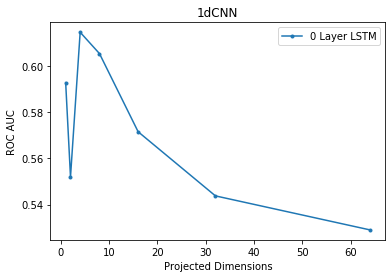

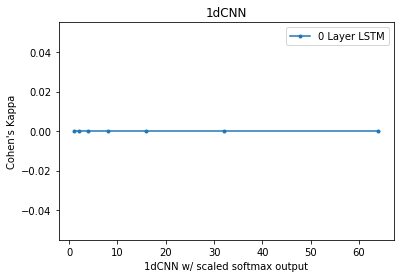

In [11]:
plt.figure()
for i in range(LAYERS):
    start = int(i*(MAX_POWER+1))
    end = int(i*(MAX_POWER+1)+MAX_POWER+1)
    plt.plot(dimention[start:end], auc[start:end], marker='.', label=f'{i} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('ROC AUC')
plt.title('1dCNN')
plt.legend()
plt.show()

plt.figure()
for i in range(LAYERS):
    start = int(i*(MAX_POWER+1))
    end = int(i*(MAX_POWER+1)+MAX_POWER+1)
    plt.plot(dimention[start:end], kappa[start:end], marker='.', label=f'{i} Layer LSTM')
plt.xlabel('1dCNN w/ scaled softmax output')
plt.ylabel('Cohen\'s Kappa')
plt.title('1dCNN')
plt.legend()
plt.show()